In [111]:
import os
import sys
import random
from pathlib import Path

root = Path('../..').resolve()
sys.path.insert(0, str(root))

import torch
import torch.nn.functional as F
import torchvision.transforms.functional as TF
from PIL import Image
import matplotlib.pyplot as plt

import src.data.augmentation as aug
import src.data.image_processing as ip
import src.attributions.gradcam as gc
from src.models.torch import Xception

In [112]:
ckpt_path = root / "out/checkpoints/best-checkpoint.ckpt"
ckpt_torch = torch.load(ckpt_path, map_location="cpu")
state_dict = ckpt_torch["state_dict"]

new_state = {}
for k,v in state_dict.items():
    name = k.replace("model.", "")
    new_state[name] = v

model = Xception(num_classes=2)
model.load_state_dict(new_state)
model.eval();
# model.cuda()

/tmp/ipykernel_2132370/3434255726.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt_torch = torch.load(ckpt_path, map_location="cpu")


In [113]:
# Settings
# dataset = "pl"
dataset = "cancer"

assert dataset in ["pl", "cancer"], "Wrong dataset name"

if dataset == "pl":
    train_dir = "data/polar_lows/train"
    train_size = 512
    mean = [0.2872, 0.2872, 0.4595]
    std = [0.1806, 0.1806, 0.2621]
    sizes = [512, 1024, 1536]
elif dataset == "cancer":
    train_dir = "data/breast_cancer/train"
    train_size = 480
    mean = [0.3289, 0.3288, 0.3288]
    std = [0.2201, 0.2201, 0.2201]
    sizes = [480, 480*2, 480*3]

In [114]:
aug_config = aug.AugConfig( 
    resize_width = train_size,
    resize_height = train_size, 
    mean = mean,
    std = std,
)

val_compose = aug.to_compose(aug_config, stage="val")

In [115]:
use_path = False
if use_path:
    img_path = os.path.join(train_dir, "pos/benign (6).png")
else:
    category = "pos"  # random.choice(['pos', 'neg'])
    chosen_image = random.choice(os.listdir(root / os.path.join(train_dir, category)))
    img_path = os.path.join(train_dir, category, chosen_image)
img = Image.open(root / img_path)
img_tens = val_compose(img).unsqueeze(0)
print(f"Original image size: {img.size}")
print(img_path)
# img_tens.shape

Original image size: (555, 463)
data/breast_cancer/train/pos/malignant (130).png


In [116]:
with torch.no_grad():
    print("Prediction:", torch.argmax(model(img_tens)).item())

Prediction: 1


(-0.5, 479.5, 479.5, -0.5)

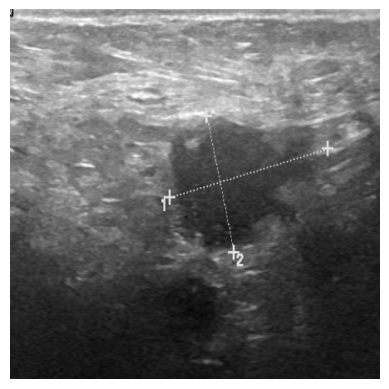

In [117]:
plt.imshow(ip.normalize_image_to_range(img_tens.squeeze(0).permute(1, 2, 0).cpu().numpy()))
plt.axis("off")

Size 480 -> Pos logit: 1.9755642414093018 -> Pred: 1
Size 960 -> Pos logit: 1.2493829727172852 -> Pred: 1
Size 1440 -> Pos logit: 1.5000396966934204 -> Pred: 1


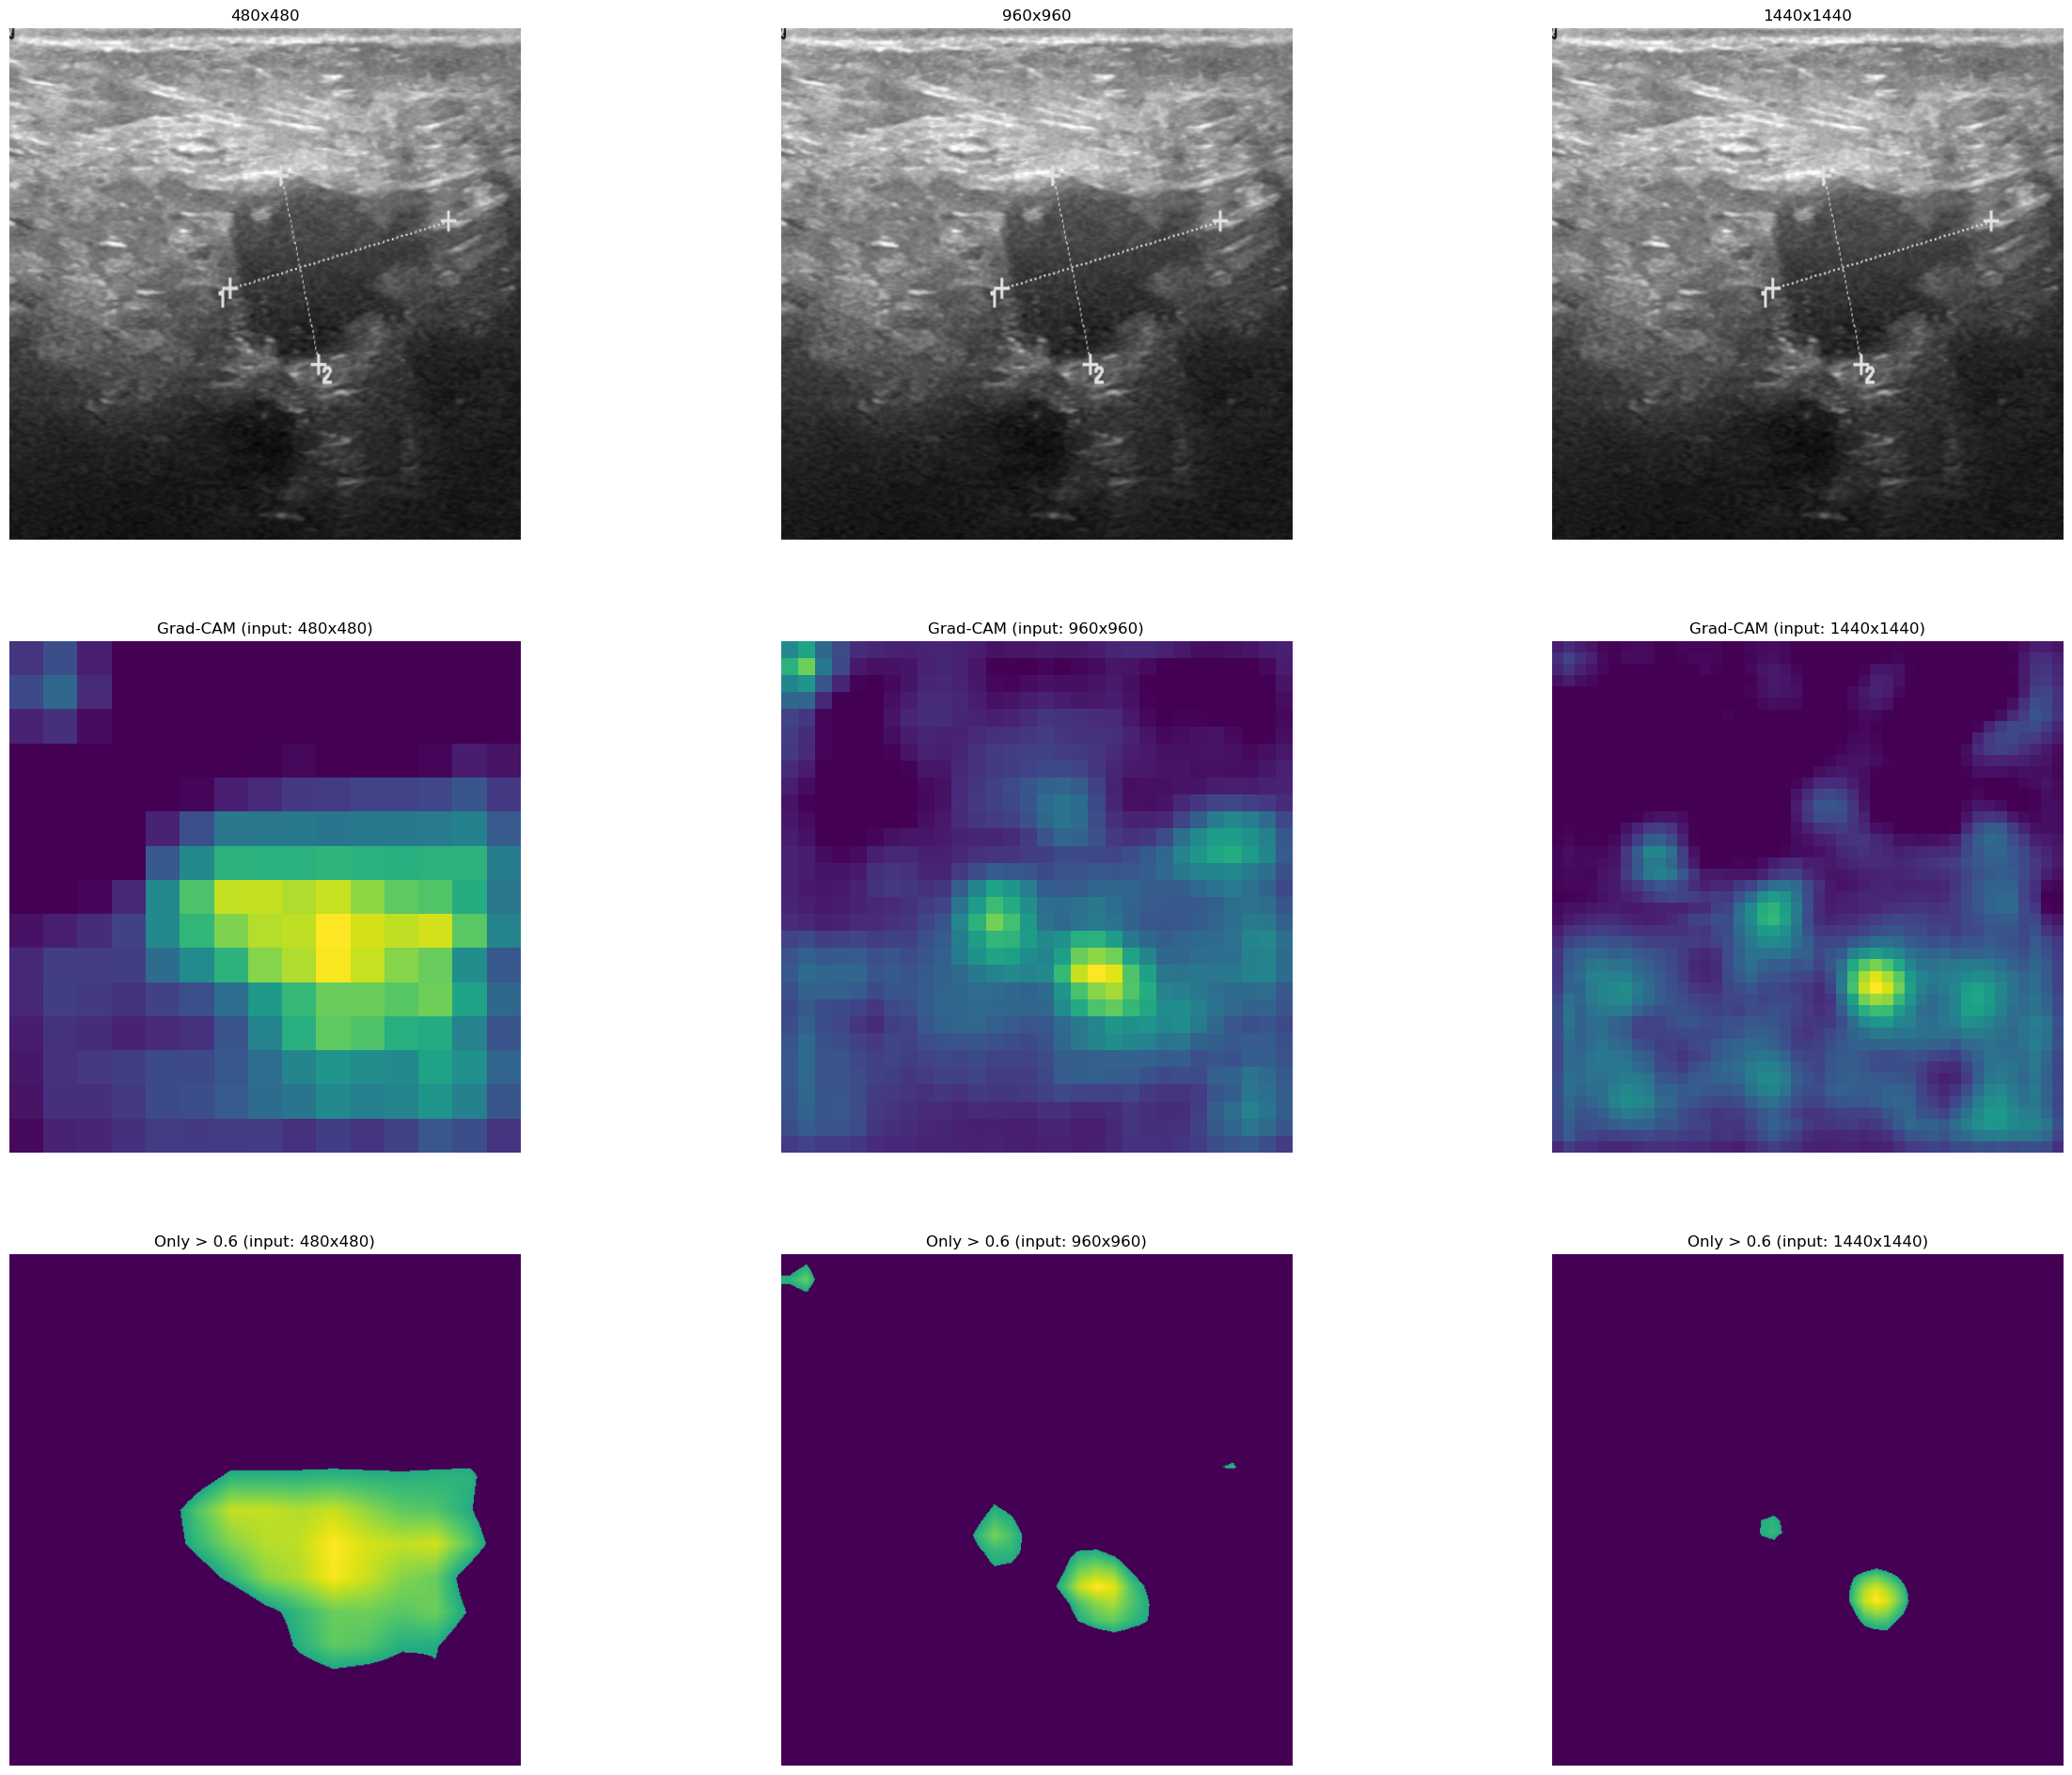

In [118]:
resized_heatmaps = []
resized_heatmaps_bil = []
ncols = len(sizes)
nrows = 3
fig, ax = plt.subplots(nrows, ncols, figsize=(10*ncols, nrows*8))
for i, s in enumerate(sizes):
    aug_config = aug.AugConfig( 
        resize_width = s,
        resize_height = s, 
        mean = mean,
        std = std,
    )
    
    val_compose = aug.to_compose(aug_config, stage="val")
    
    img_tens = val_compose(img).unsqueeze(0)
    do_augment = False
    if do_augment:
        angle = 20
        translate = [s*0.2, s*0.2] 
        img_tens = TF.affine(
            img_tens,
            angle = angle,
            translate = translate,
            scale = 1.0,
            shear = [0.0, 0.0]
        )
    
    logits = model(img_tens)[0]
    logit_pos = logits[1].item()
    pred = torch.argmax(logits).item()
    print(f"Size {s} -> Pos logit: {logit_pos} -> Pred: {pred}")
    heatmap = gc.generate_heatmap(model, img_tens, target_class=1)
    ax[0, i].imshow(
        ip.normalize_image_to_range(img_tens.squeeze(0).permute(1, 2, 0).cpu().numpy())
    )
    ax[0, i].set_title(f"{s}x{s}")
    ax[0, i].axis("off")

    ax[1, i].imshow(heatmap)
    ax[1, i].axis("off")
    ax[1, i].set_title(f"Grad-CAM (input: {s}x{s})")

    resized_heatmap_bil = F.interpolate(
        heatmap.unsqueeze(0).unsqueeze(0), size=(train_size, train_size), mode="bilinear", antialias=False
    ).squeeze(0).squeeze(0)
    min_thr = 0.6
    thr_heatmap = resized_heatmap_bil * (resized_heatmap_bil > min_thr).float()

    ax[2, i].imshow(thr_heatmap)
    ax[2, i].axis("off")
    ax[2, i].set_title(f"Only > {min_thr} (input: {s}x{s})")

    resized_heatmaps_bil.append(thr_heatmap)
    # ax[2, i].imshow(resized_heatmap_bil)
    # ax[2, i].set_title("Resized to 512x512 (Bilinear int.)")

In [119]:
H_bil = torch.stack(resized_heatmaps_bil, dim=0)
H_bil.shape

torch.Size([3, 480, 480])

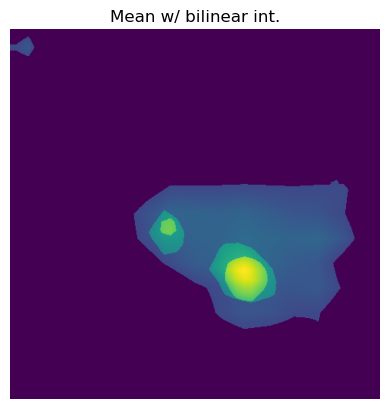

In [120]:
pixel_mean_bil = H_bil.mean(dim=0)
norm = True
if norm:
    pmin = pixel_mean_bil.min()
    pmax = pixel_mean_bil.max()
    denom = (pmax - pmin).clamp_min(1e-6)
    pixel_mean_bil = (pixel_mean_bil - pmin) / denom
plt.title("Mean w/ bilinear int.")
plt.axis("off")
plt.imshow(pixel_mean_bil)

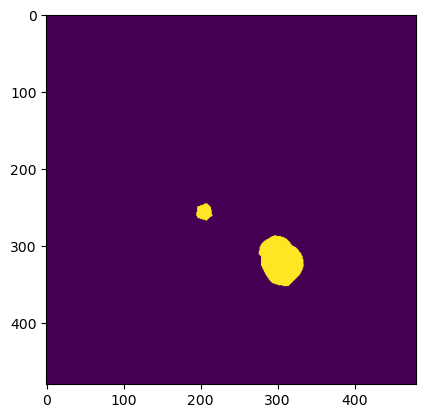

In [121]:
thr_pmean = (pixel_mean_bil > 0.6)
plt.imshow(thr_pmean)

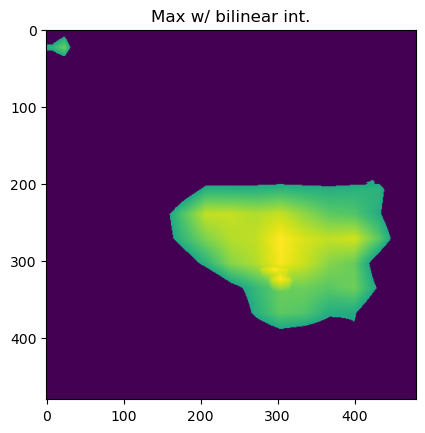

In [122]:
pixel_max_bil, _ = H_bil.max(dim=0)
plt.title("Max w/ bilinear int.")
plt.imshow(pixel_max_bil)